In [ ]:
pip install matplotlib
pip install wordcloud
pip install scikit-learn
pip install nltk
pip install seaborn

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import re


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

df = pd.read_csv('spam-2.csv', encoding="latin1", header=None, names=['label', 'text'], usecols=[0, 1], skipinitialspace=True, quotechar='"')

def clean_text(text):
    if not isinstance(text, str):
        return ''

    # Convertir a minúsculas
    text = text.lower()
    
    # Tokenizar
    tokens = word_tokenize(text)
    
    # Eliminar puntuación y números
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    
    # Eliminar palabras vacías o tokens vacíos
    tokens = [token for token in tokens if token not in stopwords.words('english') and token.isalpha()]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

df = df.drop(df.index[0])

print(df[['text', 'clean_text']])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlos.lopez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlos.lopez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlos.lopez\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                   text  \
1     Go until jurong point, crazy.. Available only ...   
2                         Ok lar... Joking wif u oni...   
3     Free entry in 2 a wkly comp to win FA Cup fina...   
4     U dun say so early hor... U c already then say...   
5     Nah I don't think he goes to usf, he lives aro...   
...                                                 ...   
5568  This is the 2nd time we have tried 2 contact u...   
5569              Will Ì_ b going to esplanade fr home?   
5570  Pity, * was in mood for that. So...any other s...   
5571  The guy did some bitching but I acted like i'd...   
5572                         Rofl. Its true to its name   

                                             clean_text  
1     go jurong point crazi avail bugi n great world...  
2                                 ok lar joke wif u oni  
3     free entri wkli comp win fa cup final tkt st m...  
4                   u dun say earli hor u c alreadi say  
5

In [8]:
def calculate_word_frequencies(dataframe):
    spam_messages = dataframe[dataframe['label'] == 'spam']
    ham_messages = dataframe[dataframe['label'] == 'ham']
    
    spam_words = ' '.join(spam_messages['clean_text']).split()
    ham_words = ' '.join(ham_messages['clean_text']).split()
    
    spam_word_count = pd.Series(spam_words).value_counts()
    ham_word_count = pd.Series(ham_words).value_counts()
    
    total_spam = len(spam_messages)
    total_ham = len(ham_messages)
    
    return spam_word_count, ham_word_count, total_spam, total_ham

In [10]:
def calculate_probabilities(dataframe):
    spam_word_count, ham_word_count, total_spam, total_ham = calculate_word_frequencies(dataframe)
    word_probabilities = {}
    for word in set(spam_word_count.keys()).union(set(ham_word_count.keys())):
        p_word_given_spam = spam_word_count.get(word, 0) / total_spam
        p_word_given_ham = ham_word_count.get(word, 0) / total_ham
        p_spam = total_spam / (total_spam + total_ham)
        p_ham = total_ham / (total_spam + total_ham)
        
        if p_word_given_spam + p_word_given_ham > 0:
            p_spam_given_word = (p_word_given_spam * p_spam) / (p_word_given_spam * p_spam + p_word_given_ham * p_ham)
        else:
            p_spam_given_word = 0
        
        word_probabilities[word] = p_spam_given_word
    return word_probabilities

In [65]:
def predict_spam(message, word_probs, threshold=0.5):
    words = clean_text(message).split()
    recognized_words = [word for word in words if word in word_probs]
    unknown_words = [word for word in words if word not in word_probs]
    
    print(f"Reconocidas: {recognized_words}")
    print(f"Desconocidas: {unknown_words}")
    
    if not recognized_words:  # Si no hay palabras reconocidas
        return 'ham', 0.0, recognized_words, unknown_words  # Devuelve 0.0 como probabilidad de SPAM

    # Solo usar probabilidades para palabras reconocidas
    probs = [word_probs[word] for word in recognized_words if word in word_probs]
    
    if not probs:  # Si no hay probabilidades válidas para calcular
        return 'ham', 0.0, recognized_words, unknown_words
    
    # Mostrar las probabilidades de cada palabra reconocida de ser spam
    print("Probabilidades de ser SPAM para cada palabra reconocida:")
    for word, prob in zip(recognized_words, probs):
        print(f"{word}: {prob:.4f}")
    
    # Calcular la probabilidad de SPAM usando la fórmula combinada para múltiples palabras
    numerador = np.prod(probs)
    denominador = numerador + np.prod([1 - p for p in probs])

    spam_prob = numerador / denominador if denominador != 0 else 0  # Asegurar que el denominador no sea cero

    result = 'spam' if spam_prob >= threshold else 'ham'
    return result, spam_prob, recognized_words, unknown_words



# def predict_spam(message, word_probs, threshold=0.5):
#     words = clean_text(message).split()
#     recognized_words = [word for word in words if word in word_probs]
#     unknown_words = [word for word in words if word not in word_probs]
    
#     print(f"Reconocidas: {recognized_words}")
#     print(f"Desconocidas: {unknown_words}")
    
#     if not recognized_words:  # Si no hay palabras reconocidas
#         return 'ham', 0.0, recognized_words, unknown_words  # Devuelve 0.0 como probabilidad de SPAM

#     # Solo usar probabilidades para palabras reconocidas
#     probs = [word_probs[word] for word in recognized_words if word in word_probs]
    
#     if not probs:  # Si no hay probabilidades válidas para calcular
#         return 'ham', 0.0, recognized_words, unknown_words
    
#     # Mostrar las probabilidades de cada palabra reconocida de ser spam
#     print("Probabilidades de ser SPAM para cada palabra reconocida:")
#     for word, prob in zip(recognized_words, probs):
#         print(f"{word}: {prob:.4f}")
    
#     # Calcular la probabilidad de SPAM usando la nueva función de cálculo combinado para múltiples palabras
#     spam_prob = calculate_spam_probability(probs)
    
#     result = 'spam' if spam_prob >= threshold else 'ham'
#     return result, spam_prob, recognized_words, unknown_words

# def calculate_spam_probability(probs, epsilon=1e-10):
#     # Ajustar probabilidades para evitar logaritmo de cero
#     adjusted_probs = [max(min(p, 1 - epsilon), epsilon) for p in probs]

#     # Usar logaritmos para el cálculo para mejorar la estabilidad numérica
#     log_probs = np.log(adjusted_probs)  # Logaritmos de las probabilidades de SPAM
#     log_not_probs = np.log([1 - p for p in adjusted_probs])  # Logaritmos de las probabilidades de no-SPAM

#     # Suma de logaritmos para calcular productos de probabilidades
#     log_product_probs = np.sum(log_probs)
#     log_product_not_probs = np.sum(log_not_probs)

#     # Exponenciar para obtener los productos originales de probabilidades
#     product_probs = np.exp(log_product_probs)
#     product_not_probs = np.exp(log_product_not_probs)

#     # Calcular la probabilidad final de SPAM
#     spam_probability = product_probs / (product_probs + product_not_probs)
#     return spam_probability



In [66]:
# División del dataset y cálculo de métricas
train, test = train_test_split(df, test_size=0.2, stratify=df['label'])
word_probabilities = calculate_probabilities(train)

In [67]:
# Cantidad de palabras en el subconjunto de entrenamiento
train_word_count = train['clean_text'].str.split().map(len).sum()

# Cantidad de palabras en el subconjunto de pruebas
test_word_count = test['clean_text'].str.split().map(len).sum()

print(f"Total de palabras en el conjunto de entrenamiento: {train_word_count}")
print(f"Total de palabras en el conjunto de pruebas: {test_word_count}")

# Contar la proporción de HAM y SPAM en el subconjunto de entrenamiento
train_label_counts = train['label'].value_counts(normalize=True) * 100

# Contar la proporción de HAM y SPAM en el subconjunto de pruebas
test_label_counts = test['label'].value_counts(normalize=True) * 100

print("Proporción de etiquetas en el conjunto de entrenamiento:")
print(train_label_counts)
print("\nProporción de etiquetas en el conjunto de pruebas:")
print(test_label_counts)

Total de palabras en el conjunto de entrenamiento: 39836
Total de palabras en el conjunto de pruebas: 9574
Proporción de etiquetas en el conjunto de entrenamiento:
label
ham     86.582903
spam    13.417097
Name: proportion, dtype: float64

Proporción de etiquetas en el conjunto de pruebas:
label
ham     86.636771
spam    13.363229
Name: proportion, dtype: float64


In [68]:
# # Evaluación en el conjunto de prueba
# results = test['text'].apply(lambda x: predict_spam(x, word_probabilities))
# predictions, recognized, unknown = zip(*results)
# print(confusion_matrix(test['label'], predictions))
# print(classification_report(test['label'], predictions))
# print("Palabras reconocidas y desconocidas en un ejemplo de mensaje:")
# print(f"Reconocidas: {recognized[0]}, Desconocidas: {unknown[0]}")

def evaluate_model(test_set, word_probabilities):
    predictions = []
    spam_probs = []
    recognized_words = []
    unknown_words = []

    # Evaluar cada mensaje en el conjunto de prueba
    for index, text in enumerate(test_set['text']):
        result, spam_prob, recognized, unknown = predict_spam(text, word_probabilities)
        predictions.append(result)
        spam_probs.append(spam_prob)
        recognized_words.append(recognized)
        unknown_words.append(unknown)

        # Imprimir la clasificación y detalles del mensaje
        print(f"Mensaje {index + 1}: '{text}'")
        print(f"Clasificado como: {result}")
        print(f"Probabilidad de SPAM: {spam_prob:.4f}")
        print("---------------------------------------------------------------")

    # Convertir las listas de resultados en arrays para utilizar en metrics
    predictions = np.array(predictions)

    # Mostrar la matriz de confusión y el informe de clasificación
    print("Matriz de Confusión y Reporte de Clasificación:")
    print(confusion_matrix(test_set['label'], predictions))
    print(classification_report(test_set['label'], predictions))

    return predictions, spam_probs, recognized_words, unknown_words

# Ejecutar la evaluación
predictions, spam_probs, recognized_words, unknown_words = evaluate_model(test, word_probabilities)



Reconocidas: ['chat', 'get', 'entri', 'chat', 'room', 'cost', 'repli', 'call', 'subscrib', 'p', 'pm', 'bcm', 'box', 'ldn', 'wcnxx']
Desconocidas: ['hack', 'backdoor', 'fraction', 'neo', 'dp']
Probabilidades de ser SPAM para cada palabra reconocida:
chat: 0.7955
get: 0.2027
entri: 1.0000
chat: 0.7955
room: 0.0000
cost: 0.5385
repli: 0.6641
call: 0.5418
subscrib: 1.0000
p: 0.8806
pm: 0.2963
bcm: 1.0000
box: 0.9070
ldn: 1.0000
wcnxx: 1.0000
Mensaje 1: 'Hack Chat. Get backdoor entry into 121 chat rooms at a fraction of the cost. Reply NEO69 or call 09050280520, to subscribe 25p pm. DPS, Bcm box 8027 Ldn, wc1n3xx'
Clasificado como: ham
Probabilidad de SPAM: 0.0000
---------------------------------------------------------------
Reconocidas: ['good', 'afternoon', 'love', 'go', 'day', 'hope', 'mayb', 'got', 'lead', 'job', 'think', 'boytoy', 'send', 'passion', 'kiss', 'across', 'sea']
Desconocidas: []
Probabilidades de ser SPAM para cada palabra reconocida:
good: 0.0372
afternoon: 0.0000
love: 

In [15]:
# Configuraciones para las visualizaciones
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

Distribución de mensajes

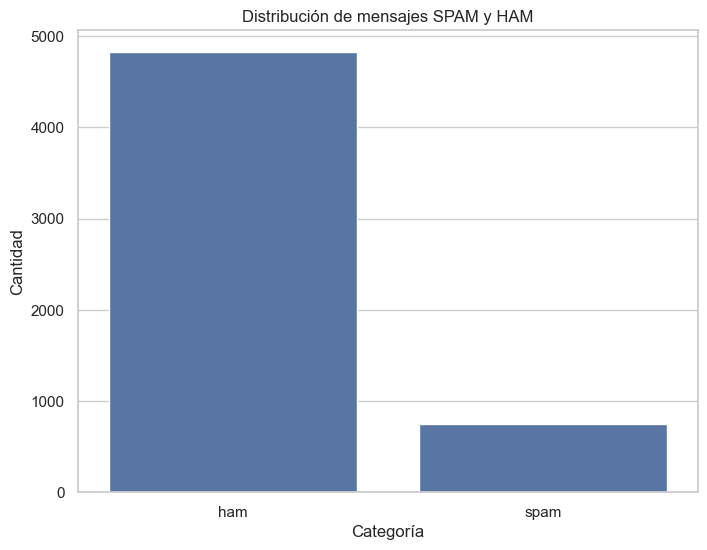

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribución de mensajes SPAM y HAM')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.show()

Longitud de mensajes

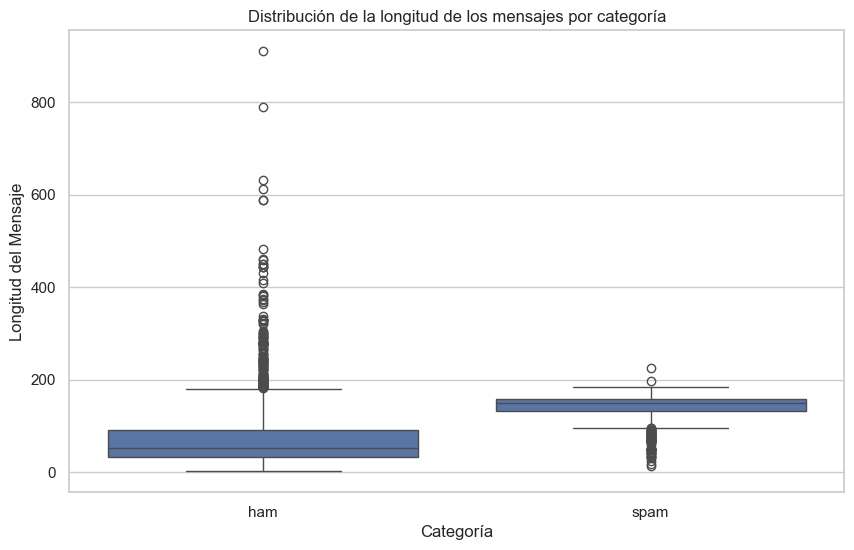

In [18]:
df['length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='length', data=df)
plt.title('Distribución de la longitud de los mensajes por categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud del Mensaje')
plt.show()


Palabras más comunes en cada categoría

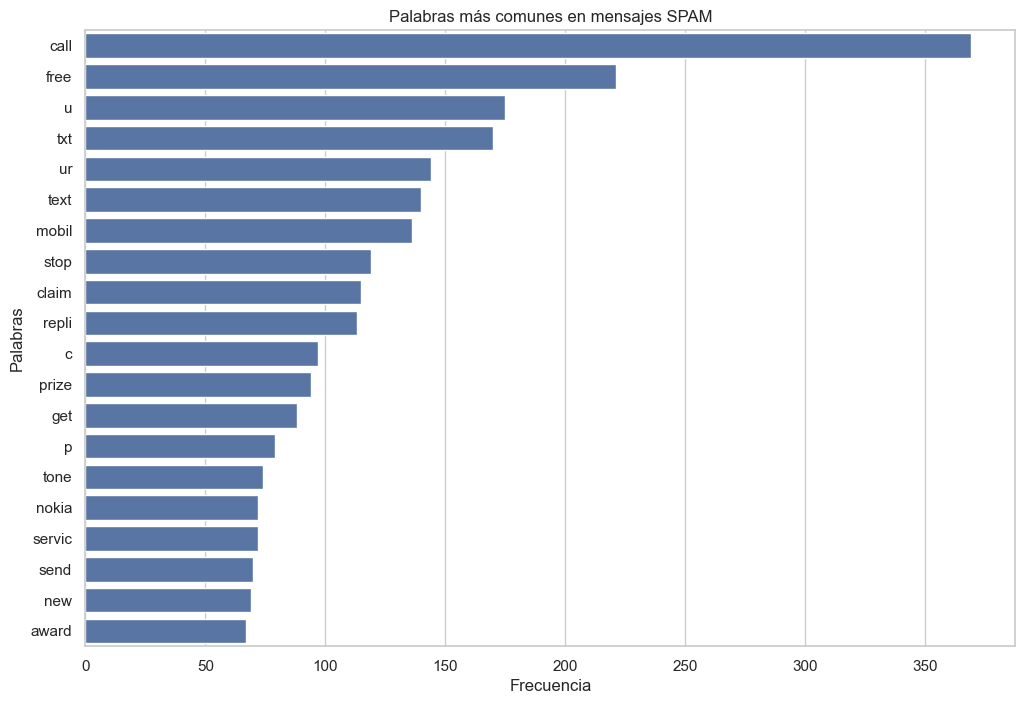

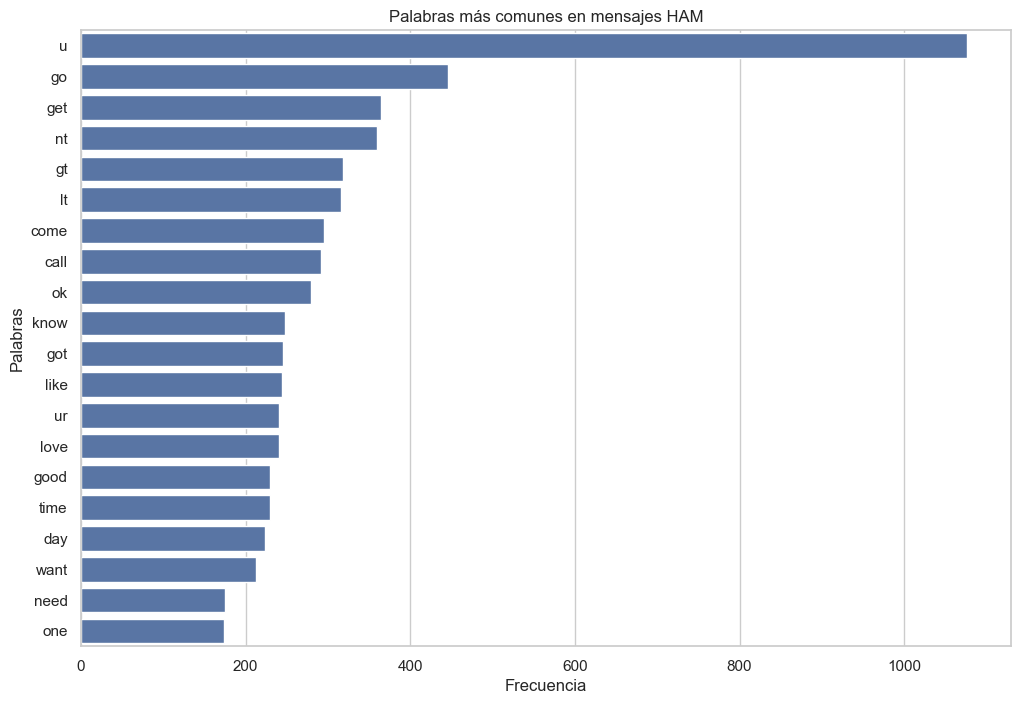

In [19]:
def count_words(text):
    words = []
    for message in df[df['label'] == text]['clean_text']:
        words.extend(message.split())
    return Counter(words)

# Conteo de palabras para SPAM
spam_words = count_words('spam')
most_common_spam = spam_words.most_common(20)

# Conteo de palabras para HAM
ham_words = count_words('ham')
most_common_ham = ham_words.most_common(20)

# Función para graficar las palabras más comunes
def plot_most_common_words(common_words, title):
    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts, y=words)
    plt.title(f'Palabras más comunes en mensajes {title}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabras')
    plt.show()

# Gráficas
plot_most_common_words(most_common_spam, 'SPAM')
plot_most_common_words(most_common_ham, 'HAM')


Diversidad de Palabras por Categoría

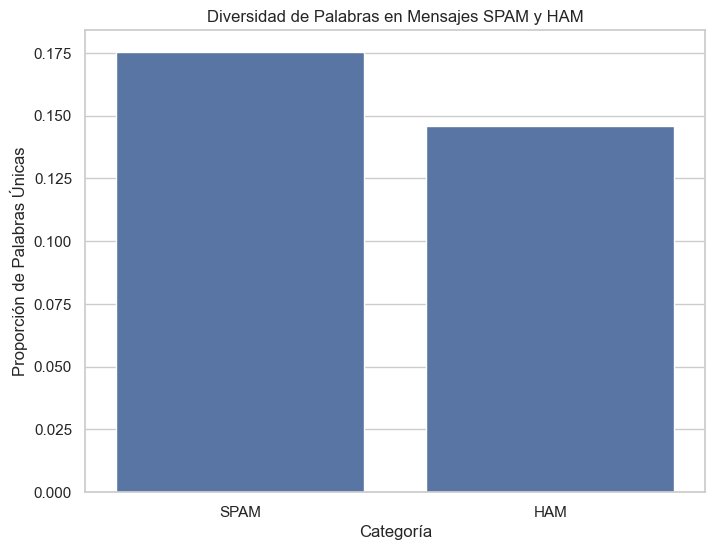

In [20]:
def calculate_word_diversity(text):
    words = []
    for message in df[df['label'] == text]['clean_text']:
        words.extend(message.split())
    unique_words = set(words)
    return len(unique_words) / len(words)

# Diversidad de palabras en SPAM y HAM
spam_diversity = calculate_word_diversity('spam')
ham_diversity = calculate_word_diversity('ham')

# Visualización de la diversidad de palabras
labels = ['SPAM', 'HAM']
values = [spam_diversity, ham_diversity]

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=values)
plt.title('Diversidad de Palabras en Mensajes SPAM y HAM')
plt.xlabel('Categoría')
plt.ylabel('Proporción de Palabras Únicas')
plt.show()


 Distribución de la Cantidad de Palabras por Mensaje

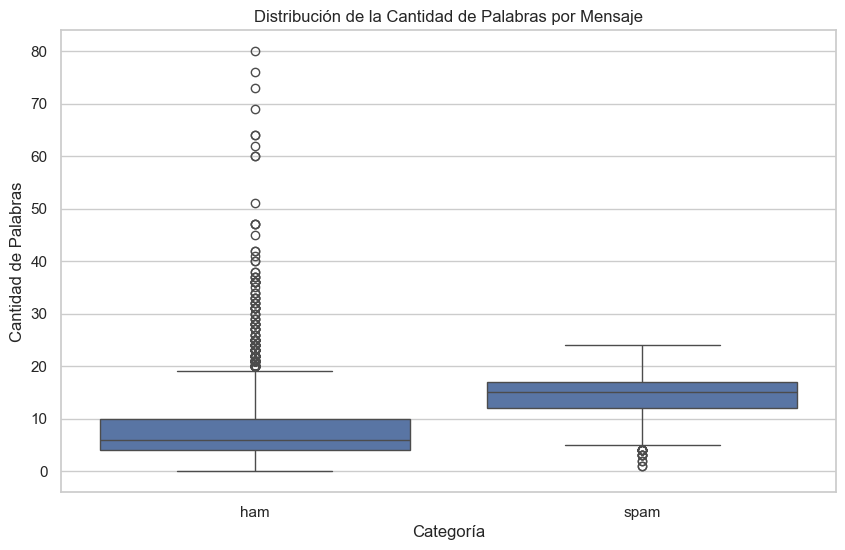

In [21]:
# Calcula la cantidad de palabras por mensaje
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Distribución de la Cantidad de Palabras por Mensaje')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Palabras')
plt.show()
